# NMF Topic Models

Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. One approach for topic modelling is to apply *matrix factorisation* methods, such as *Non-negative Matrix Factorisation (NMF)*. In this notebook we look at how to apply NMF using the *scikit-learn* library in Python.

### Applying NMF

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 4551 X 10285 document-term matrix


The key input parameter to NMF is the number of topics to generate *k*. For the moment, we will pre-specify a guessed value, for demonstration purposes.

In [2]:
k = 10

Another choice for NMF revolves around initialisation. Most commonly, NMF involves using random initialisation to populate the values in the factors W and H. Depending on the random seed that you use, you may get different results on the same dataset. Instead, using SVD-based initialisation provides more reliable results.

In [3]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

### Examining the Output

NMF produces to factor matrices as its output: *W* and *H*.

The *W* factor contains the document membership weights relative to each of the *k* topics. Each row corresponds to a single document, and each column correspond to a topic.

In [4]:
W.shape

(4551, 10)

For instance, for the first document, we see that it is strongly associated with one topic. However,  each document can be potentially associated with multiple topics to different degrees.

In [5]:
# round to 2 decimal places for display purposes
W[0,:].round(2)

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.13,  0.  ,  0.  ,  0.  ,  0.  ,  0.01])

The *H* factor contains the term weights relative to each of the *k* topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [6]:
H.shape

(10, 10285)

For instance, for the term "brexit", we see that it is strongly associated with a single topic. Again, in some cases each term can be associated with multiple topics.

In [7]:
term_index = terms.index('brexit')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([ 0.99,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,  0.25,  0.  ])

### Topic Descriptors

The top ranked terms from the *H* factor for each topic can give us an insight into the content of that topic. This is often called the *topic descriptor*. Let's define a function that extracts the descriptor for a specified topic: 

In [8]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

We can now get a descriptor for each topic using the top ranked terms (e.g. top 10):

In [9]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, uk, brexit, britain, european, leave, europe, vote, referendum, trade
Topic 02: trump, clinton, donald, republican, campaign, president, hillary, cruz, sanders, presidential
Topic 03: film, films, movie, star, director, hollywood, actor, story, drama, cinema
Topic 04: league, season, leicester, goal, premier, united, city, liverpool, game, ball
Topic 05: bank, banks, banking, financial, rbs, customers, shares, deutsche, barclays, lloyds
Topic 06: health, nhs, care, patients, mental, doctors, hospital, people, services, junior
Topic 07: album, music, band, song, pop, songs, rock, love, sound, bowie
Topic 08: facebook, internet, online, twitter, users, google, people, media, company, amazon
Topic 09: labour, party, corbyn, cameron, referendum, vote, voters, campaign, johnson, minister
Topic 10: women, abortion, woman, men, cancer, female, ireland, girls, rights, northern


The rankings above do not show the strength of association for the different terms. We can represent the distribution of the weights for the top terms in a topic using a *matplotlib* horizontal bar chart.

In [10]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

Define a function to create a bar chart for the specified topic, based on the *H* factor from the current NMF model:

In [11]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

So for instance, for the 7th topic we can generate a plot with the top 15 terms using:

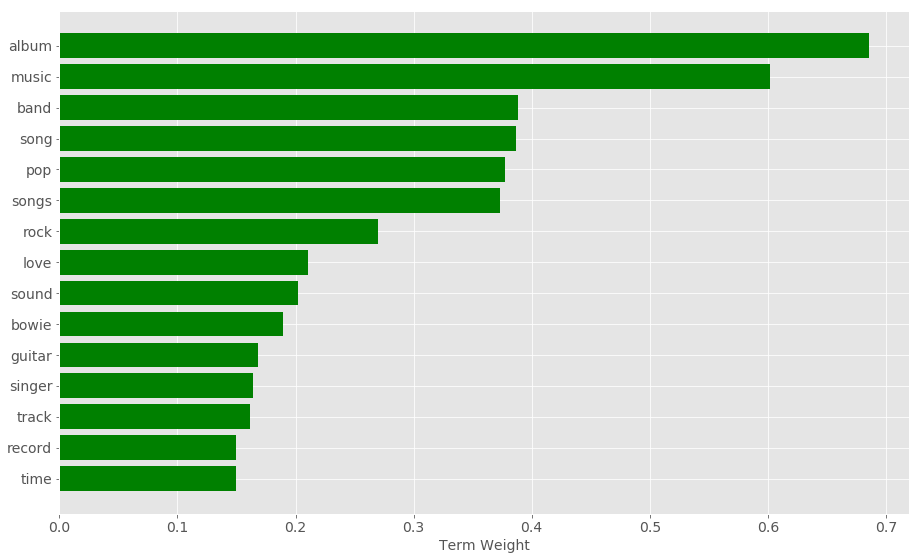

In [12]:
plot_top_term_weights( terms, H, 6, 15 )

### Most Relevant Documents

We can also look at the snippets for the top-ranked documents for each topic. We'll define a function to produce this ranking also.

In [13]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

For instance, for the first topic listed above, the top 10 documents are:

In [14]:
topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Brexit X-men: how the prime minister’s key negotiators are coping When Boris Johnson was working for
02. Archbishop accuses Farage of racism and 'accentuating fear for political gain' – EU referendum live 
03. Brexit could shift Europe's political centre of gravity, says Fitch A vote for Brexit in next month’
04. EU leaders line up to insist UK will pay a high price for Brexit stance Britain and the EU appear mo
05. Would Brexit make UK businesses less competitive? In this week’s EU referendum Q&A our panel discuss
06. David Cameron: being in the EU gives Britain key counter-terrorism information David Cameron has sai
07. Slovakian foreign minister: I will support any measure to stop Brexit The new Slovakian EU presidenc
08. Brexit weekly briefing: we're going to be kept in the dark Welcome to the weekly Brexit briefing, a 
09. What would Brexit mean for housing, regeneration and central government? Housing and regeneration: T
10. Cameron names referendum date as Gove declares for 

Similarly, for the second topic:

In [15]:
topic_snippets = get_top_snippets( snippets, W, 1, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Donald Trump: money raised by Hillary Clinton is 'blood money' – as it happened Hillary Clinton deli
02. Second US presidential debate – as it happened Here’s how searches for “Hillary Clinton” and “Donald
03. Trump campaign reportedly vetting Christie, Gingrich as potential running mates – as it happened Don
04. Donald Trump hits delegate count needed for Republican nomination – as it happened On the one hand, 
05. Trump: 'Had I been president, Capt Khan would be alive today' – as it happened Speaking with ABC New
06. Clinton seizes on Trump tweets for day of campaigning in Florida – as it happened Donald Trump was a
07. Melania Trump defends husband's 'boy talk' in CNN interview – as it happened Speaking to CNN’s Ander
08. Hillary Clinton: 'I'm sick of the Sanders campaign's lies' – as it happened One of the most importan
09. Donald Trump at the White House: Obama reports 'excellent conversation' – as it happened Are you adj
10. Donald Trump: Hillary Clinton has 'no right to be r

### Exporting the Results

If we want to keep this topic model for later user, we can save it using *joblib*:

In [16]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k) 

['articles-model-nmf-k10.pkl']